In [2]:
import os
import sys
import tifffile as tiff
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

sys.path.append("/home/phillip/documents/lysozyme")
import src
from src.lysozyme_stain_quantification.crypts.identify_potential_crypts_ import identify_potential_crypts

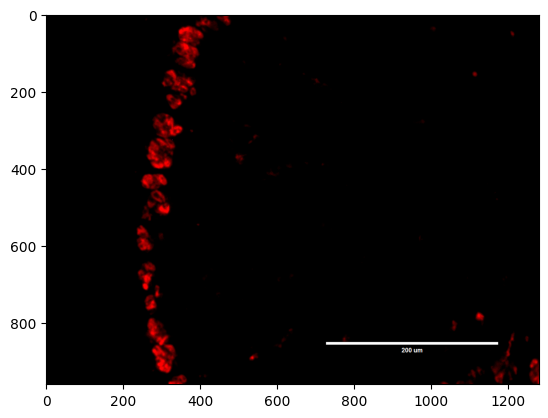

In [67]:

from src.lysozyme_stain_quantification.crypts.remove_edge_touching_regions_mod import remove_edge_touching_regions_sk
from src.lysozyme_stain_quantification.crypts.scoring_selector_mod import scoring_selector

max_regions = 8
image = tiff.imread("/home/phillip/documents/lysozyme/lysozyme images/lysozyme retakes2.0/G5FR - 1.tif")#"/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G2/G2FL - 3.tif")
plt.imshow(image)

In [68]:

rfp = image[...,0]
dapi = image[...,2]


regions = remove_edge_touching_regions_sk(identify_potential_crypts(
    crypt_img=rfp,
    tissue_image=dapi,
    blob_size_px=int(50.0 * 0.4476),

))


In [87]:
weights = {
        "circularity": 0.35,  # Most important - want circular regions
        "area": 0.15,         # Second - want consistent sizes
        "line_fit": 0.25,     # Moderate - want aligned regions
        "red_intensity": 0.35,  # Moderate - want bright regions
        
        }
best_crypts, crypt_scores = scoring_selector(
        label_img=regions,
        raw_img=rfp,
        max_regions=max_regions,
        return_details=True,
        weights=weights
    )
#print(crypt_scores['properties_df'])

_, best_crypt_scores = scoring_selector(
        label_img=best_crypts,
        raw_img=rfp,
        max_regions=False,
        return_details=True,
        weights=weights
    )
print(best_crypt_scores['properties_df']['quality_score'])

0    0.351423
1    0.354773
2    0.379581
3    0.400436
4    0.413052
5    0.414165
6    0.435659
7    0.489709
Name: quality_score, dtype: float64


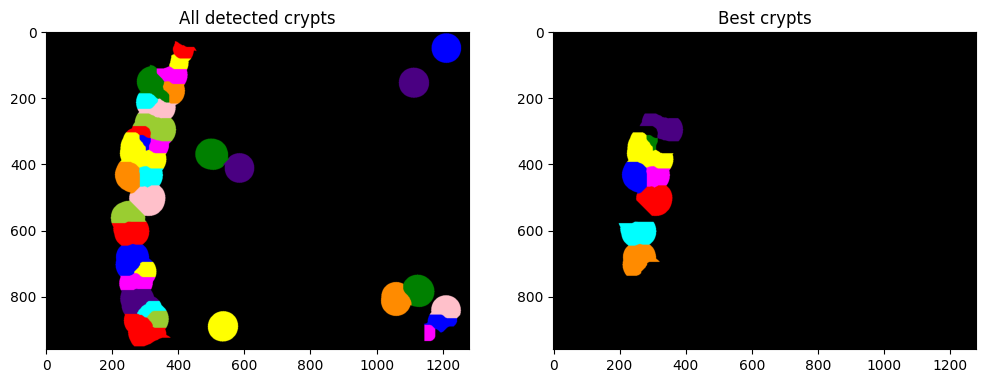

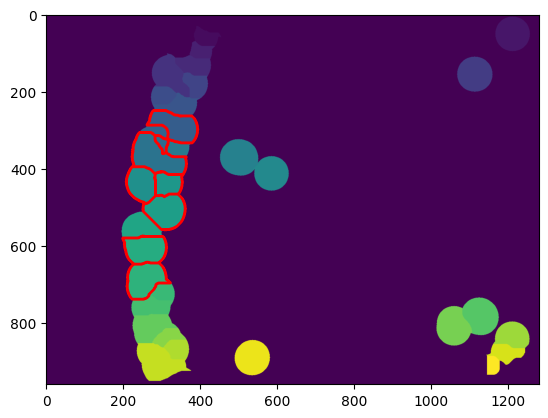

In [70]:
from skimage.color import label2rgb 
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(label2rgb(regions)); ax[0].set_title("All detected crypts")
ax[1].imshow(label2rgb(best_crypts)); ax[1].set_title("Best crypts")
plt.show()
from skimage.segmentation import find_boundaries
boundaries = find_boundaries(best_crypts)
subject = np.zeros_like(image)
subject[boundaries] = [255,0,0]
plt.imshow(regions)
plt.contour(boundaries, colors='r')

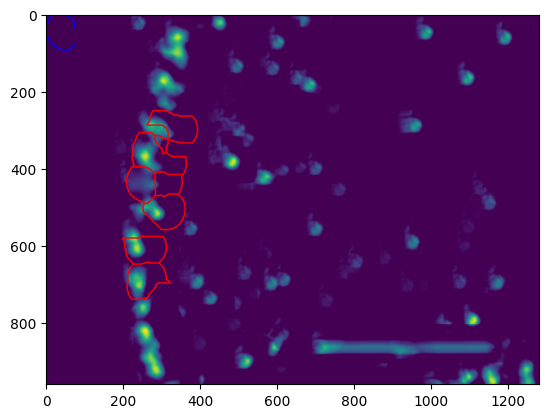

In [71]:
import scipy.ndimage as ndi
from skimage.feature import match_template
from skimage.restoration import inpaint

crypt_index = 2  # Index of the crypt to match
subject = rfp  # Image in which to search for matches

def minmax256(arr: np.ndarray):
    arr = arr.astype(np.float32)
    arr = (255*(arr - np.min(arr)) / (np.max(arr) - np.min(arr)) )
    return arr.astype(np.uint8)
def quantify_matches(detections: np.ndarray, index: int, src: np.ndarray, pad_input=True):
    #template_boundaries = find_boundaries(detections == index)
    slc = ndi.find_objects(detections == index)[0]

    crypt_binary = detections == index if src.ndim == 2 else np.stack([detections == index]*src.shape[-1], axis=-1)
    template = np.where(crypt_binary, src, np.zeros_like(src))
    template = template[slc]
    result = match_template(src, template, pad_input=pad_input)
    
    result = inpaint.inpaint_biharmonic(result, detections == index, channel_axis=None)
    result = np.maximum(result, 0)  # Collapse channel axis if present
    result = minmax256(result) # Normalize to 255
    result = result.astype(np.uint8)
    return result, template, slc

result, template, slc = quantify_matches(best_crypts, crypt_index, subject, pad_input=True)



plt.imshow(result)
plt.contour(find_boundaries(best_crypts), colors='r', linewidths=0.5)
plt.contour(find_boundaries(best_crypts[slc]), colors='b', linewidths=0.5)
plt.show()



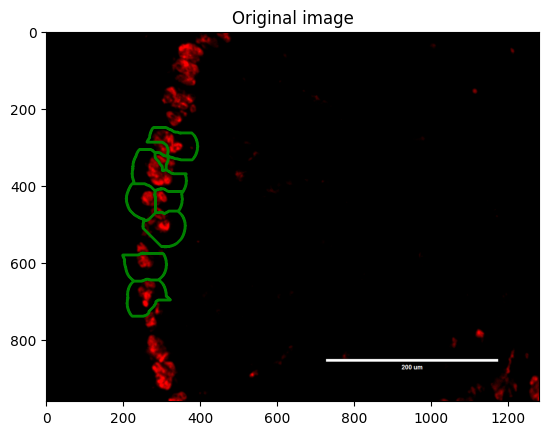

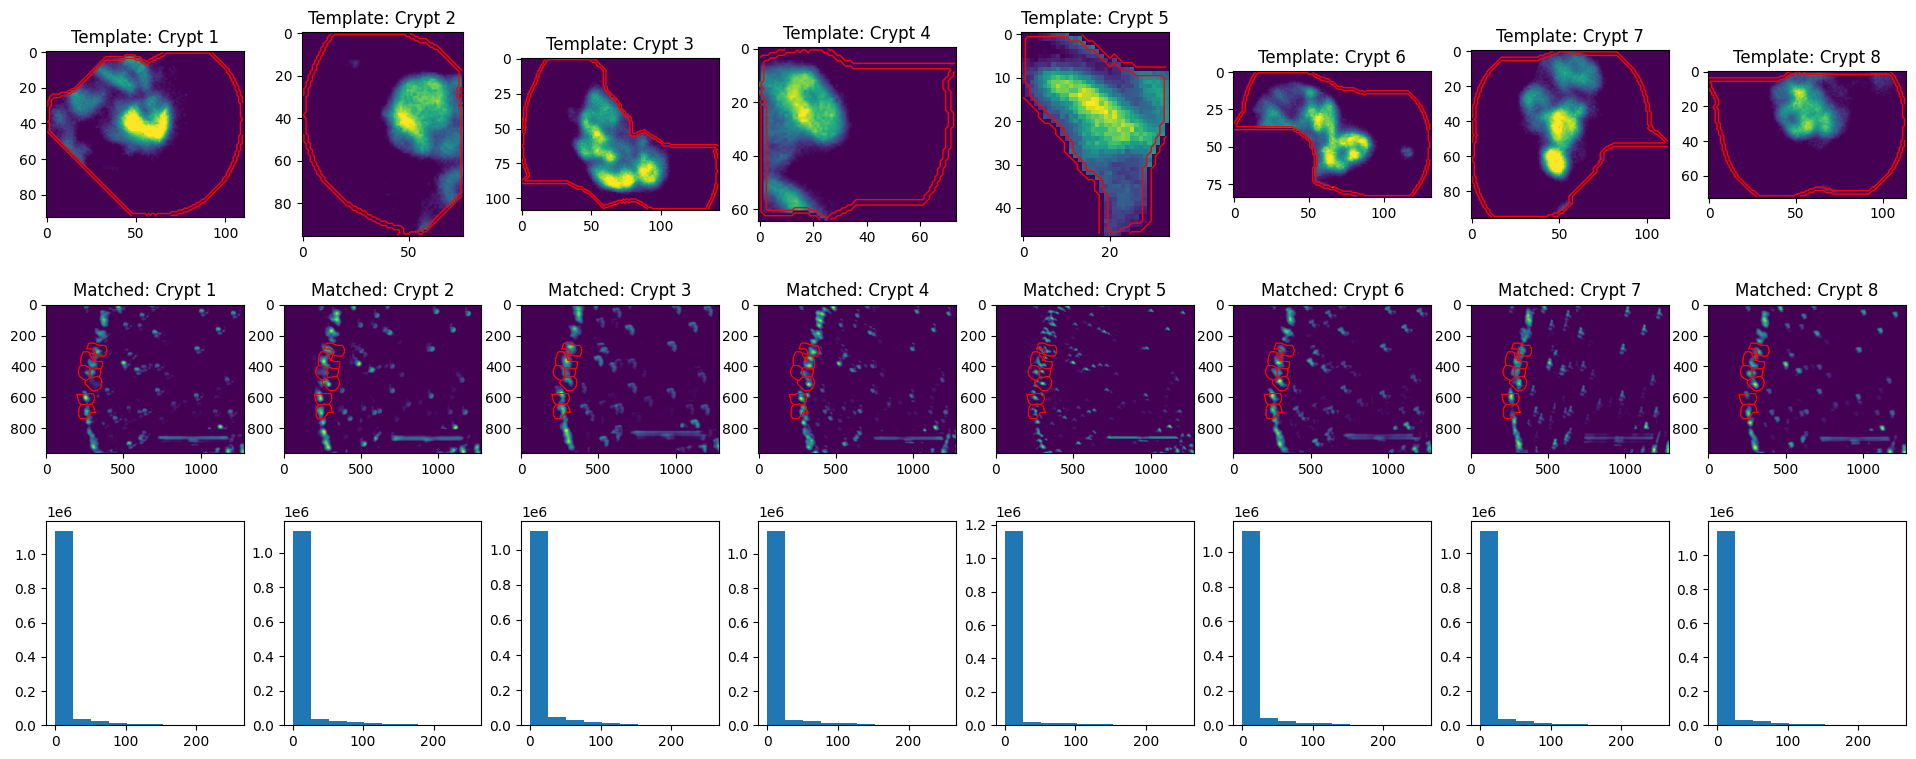

In [72]:
import scipy.ndimage as ndi
from skimage.feature import match_template
from skimage.segmentation import mark_boundaries


# show original image
plt.imshow(image)
plt.title("Original image")
plt.contour(find_boundaries(best_crypts), colors='g')
plt.show()
num_crypts = np.max(best_crypts)



match_indexes = []
def minmax256(arr: np.ndarray):
    arr = arr.astype(np.float32)
    arr = (255*(arr - np.min(arr)) / (np.max(arr) - np.min(arr)) )
    return arr.astype(np.uint8)
def quantify_matches(detections: np.ndarray, index: int, matching_image: np.ndarray[np.uint], pad_input=True):
    #template_boundaries = find_boundaries(detections == index)
    slc = ndi.find_objects(detections == index)[0]

    crypt_binary = detections == index if matching_image.ndim == 2 else np.stack([detections == index]*matching_image.shape[-1], axis=-1)
    template = np.where(crypt_binary, matching_image, np.zeros_like(matching_image))
    template = template[slc]
    result = match_template(matching_image, template, pad_input=pad_input)
    
    result = inpaint.inpaint_biharmonic(result, detections == index, channel_axis=None)
    result = np.maximum(result, 0)  # Collapse channel axis if present
    result = minmax256(result) # Normalize to 255
    result = result.astype(np.uint16)
    return result, template, slc
def create_match_stack(best_crypts, matching_image)-> tuple[np.ndarray[np.int_], list[tuple[slice,...]]]:
    match_arrays = []
    slcs = []
    for crypt_index in range(1, np.max(best_crypts)+1):
        result, template, slc = quantify_matches(best_crypts, crypt_index, matching_image, pad_input=True)
        match_arrays.append(result)
        slcs.append(slc)

    return match_arrays, slcs 

subject = rfp
result_stack, slcs = create_match_stack(best_crypts, subject)
avg_results = np.average(result_stack, axis=0)
collapsed_results =np.multiply.reduce(result_stack)


fig, ax = plt.subplots(3,num_crypts, figsize=(3*len(result_stack),9))
subject = rfp
boundaries = find_boundaries(best_crypts)


for crypt_index, (match_array, slc) in enumerate(zip(result_stack, slcs)):

    
    
    
    #ax[crypt_index, 0].imshow(mark_boundaries(subject, best_crypts==(crypt_index+1))[slc])
    ax[0, crypt_index].imshow(np.where(best_crypts==(crypt_index+1), subject, 0)[slc])
    ax[0, crypt_index].contour(find_boundaries(best_crypts==(crypt_index+1))[slc], colors='r', linewidths=1)
    ax[0, crypt_index].set_title(f"Template: Crypt {crypt_index+1}")
    
    ax[1, crypt_index].imshow(match_array)
    ax[1, crypt_index].contour(boundaries, colors='r', linewidths=0.5)
    

    ax[1, crypt_index].set_title(f"Matched: Crypt {crypt_index+1}")
    ax[2, crypt_index].hist(match_array.flatten())
    #ax[crypt_index, 2].imshow(match_template(slc, best_crypts, pad_input=True))



plt.show()





In [ ]:
print("Quality scores:", list(best_crypt_scores['properties_df']['quality_score']))
print("Result stack shape:", len(result_stack))
print("Quality scores type:", type(best_crypt_scores['properties_df']['quality_score']))

Quality scores: [0.3514227963223917, 0.35477266015062964, 0.379581288318215, 0.40043593559672014, 0.41305186792207027, 0.41416452688995875, 0.43565862102337616, 0.4897094439560175]
Result stack shape: 8
Quality scores type: <class 'pandas.core.series.Series'>


In [ ]:
# Let's check the shapes to understand the broadcasting issue
print("result_stack shape:", np.array(result_stack).shape)
print("weights shape:", np.array(best_crypt_scores['properties_df']['quality_score']).shape)
print("First result shape:", result_stack[0].shape)

result_stack shape: (8, 960, 1280)
weights shape: (8,)
First result shape: (960, 1280)


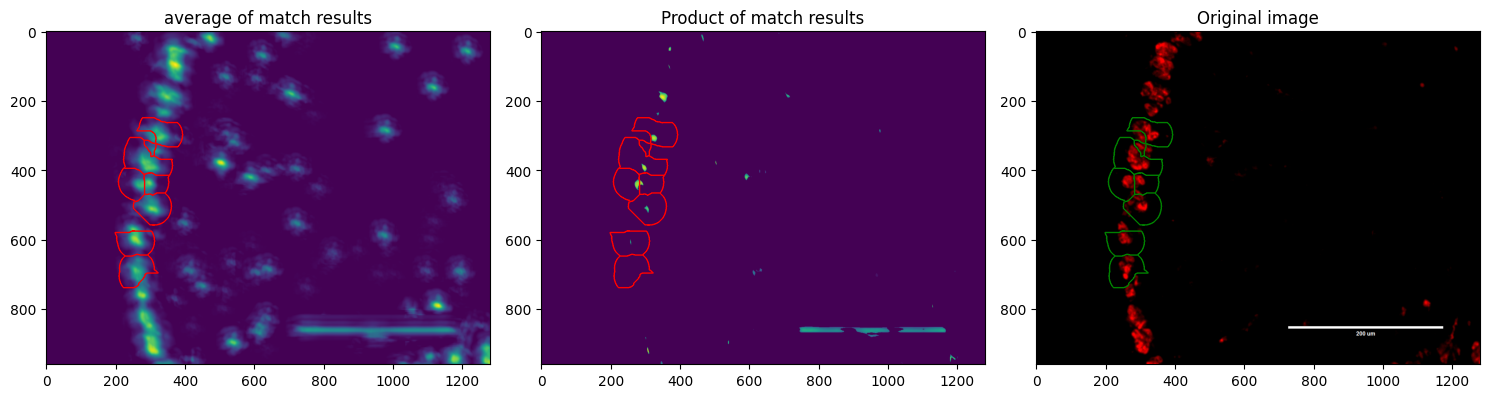

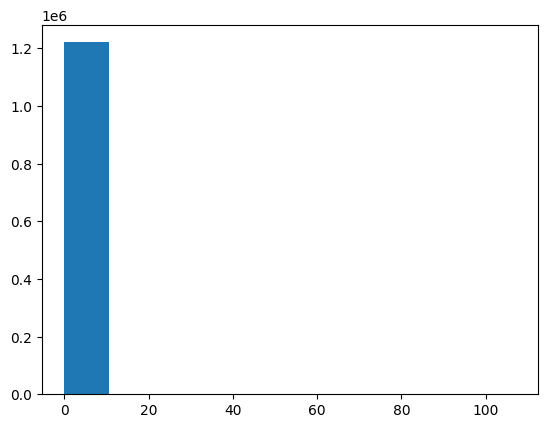

In [75]:
from scipy.stats import gmean

fig, ax = plt.subplots(1,3, figsize=(15,5))

avg_results = np.average(result_stack, axis=0)
collapsed_results = gmean(result_stack).astype(np.uint16)
ax[0].imshow(avg_results)
ax[0].set_title("average of match results")
ax[0].contour(boundaries, colors='r', linewidths=0.5)   


ax[1].imshow(collapsed_results)
ax[1].set_title("Product of match results")
ax[1].contour(boundaries, colors='r', linewidths=0.5)
ax[2].imshow(image)
ax[2].set_title("Original image")
ax[2].contour(boundaries, colors='g', linewidths=0.5)
fig.tight_layout()
fig.show()

# plt.imshow(np.multiply.reduce(result_stack))
# plt.contour(boundaries, colors='r', linewidths=0.5)
fig = plt.figure()
plt.hist(collapsed_results.flatten())
fig.show()


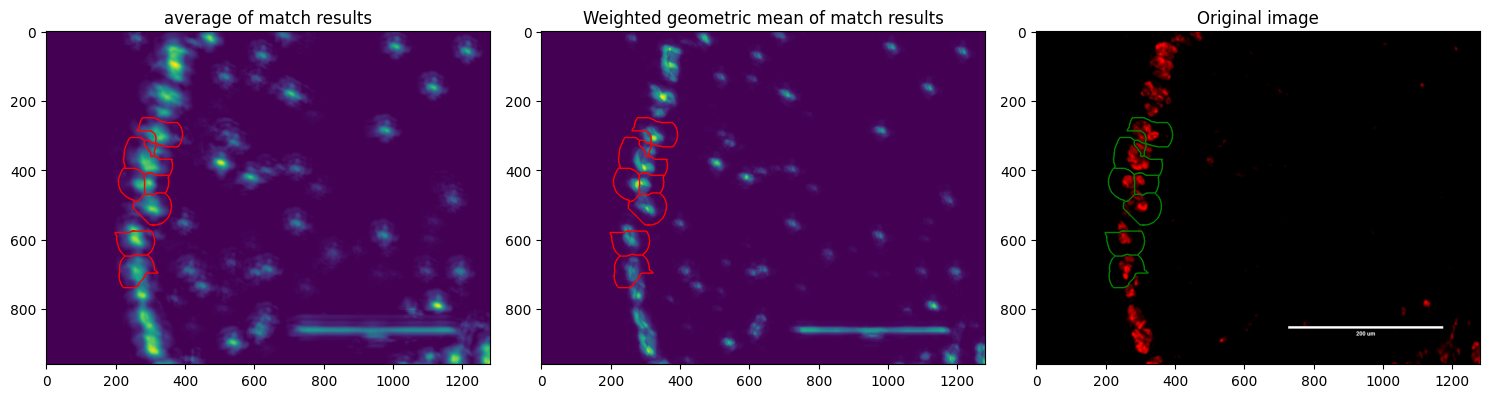

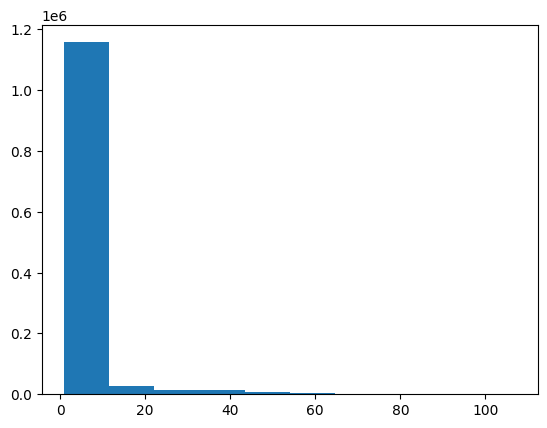

In [ ]:
from scipy.stats import gmean

fig, ax = plt.subplots(1,3, figsize=(15,5))

avg_results = np.average(result_stack, axis=0)

# Fix the geometric mean calculation - convert result_stack to proper numpy array first
result_array = np.array(result_stack)
weights_array = np.array(best_crypt_scores['properties_df']['quality_score'])

# Calculate weighted geometric mean manually since gmean with weights is having broadcasting issues
# Use the formula: exp(sum(w_i * log(x_i)) / sum(w_i))
log_results = np.log(np.maximum(result_array, 1))  # avoid log(0)
weighted_log_sum = np.sum(weights_array[:, np.newaxis, np.newaxis] * log_results, axis=0)
weight_sum = np.sum(weights_array)
collapsed_results = np.exp(weighted_log_sum / weight_sum).astype(np.uint16)

ax[0].imshow(avg_results)
ax[0].set_title("average of match results")
ax[0].contour(boundaries, colors='r', linewidths=0.5)   


ax[1].imshow(collapsed_results)
ax[1].set_title("Weighted geometric mean of match results")
ax[1].contour(boundaries, colors='r', linewidths=0.5)
ax[2].imshow(image)
ax[2].set_title("Original image")
ax[2].contour(boundaries, colors='g', linewidths=0.5)
fig.tight_layout()
fig.show()

# plt.imshow(np.multiply.reduce(result_stack))
# plt.contour(boundaries, colors='r', linewidths=0.5)
fig = plt.figure()
plt.hist(collapsed_results.flatten())
fig.show()

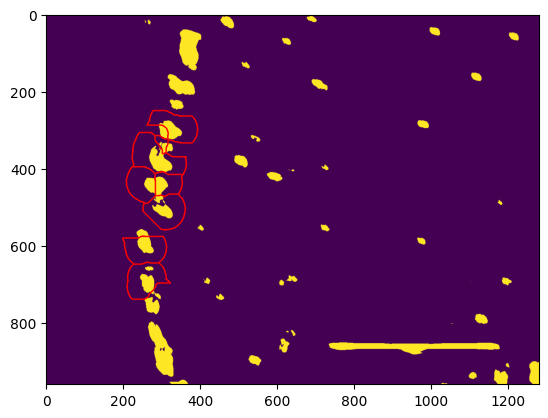

In [77]:
# test apply a  otsu to collapsed_results
plt.imshow(collapsed_results)
from skimage.filters import threshold_otsu
thresh = threshold_otsu(collapsed_results)
binary = collapsed_results > thresh
plt.imshow(binary)
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.show()

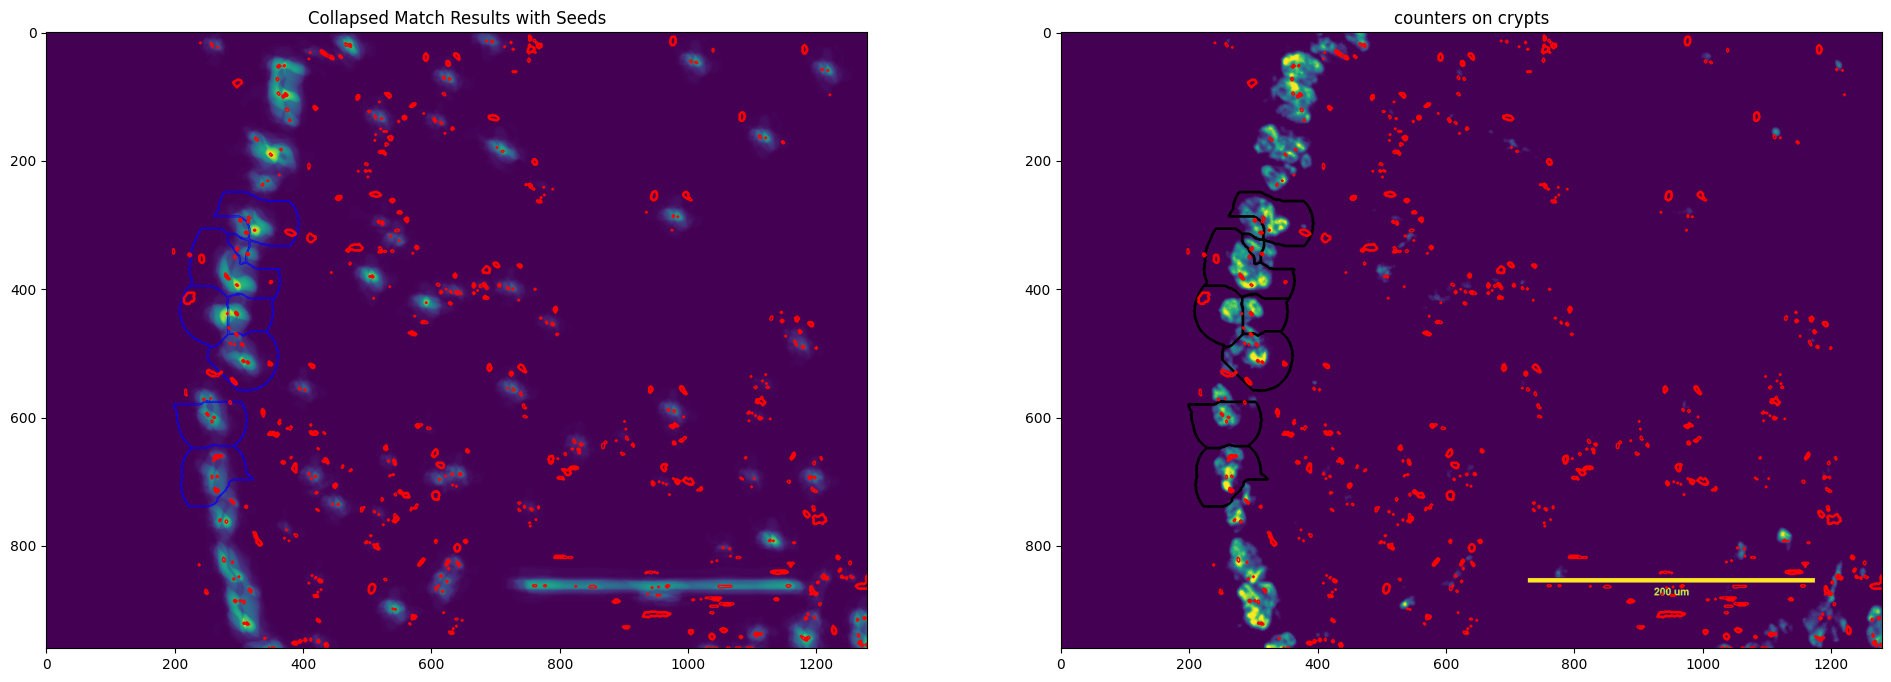

In [78]:
from skimage.morphology import local_maxima, dilation, disk, label, binary_closing,erosion,closing, local_maxima
from skimage.segmentation import watershed
from skimage.util import invert
from scipy.ndimage import distance_transform_edt as dst
from skimage.feature import peak_local_max
seeds = local_maxima(collapsed_results,connectivity=2)
indiv_seeds = label(closing(seeds, disk(4)))

fig, ax = plt.subplots(1,2, figsize=(24,8))
ax[0].imshow(collapsed_results)
ax[0].contour(boundaries, colors='b', linewidths=0.5)

ax[0].contour(find_boundaries(indiv_seeds), colors='r', linewidths=1)
ax[0].set_title('Collapsed Match Results with Seeds')


ax[1].set_title('counters on crypts')
ax[1].imshow(rfp)
ax[1].contour(boundaries, colors='black', linewidths=1)
ax[1].contour(find_boundaries(indiv_seeds), colors='red', linewidths=1)

# ax[1].imshow(label2rgb(watershed(
#     markers=label(seeds, connectivity=2),
#     image=best_crypts==0,
#     mask=best_crypts>0,)))
plt.show()
# try watershed_ift

(array([1.156376e+06, 2.843500e+04, 1.486800e+04, 1.245000e+04,
        7.287000e+03, 5.709000e+03, 2.043000e+03, 8.620000e+02,
        5.980000e+02, 1.720000e+02]),
 array([  1. ,  11.6,  22.2,  32.8,  43.4,  54. ,  64.6,  75.2,  85.8,
         96.4, 107. ]),
 <BarContainer object of 10 artists>)

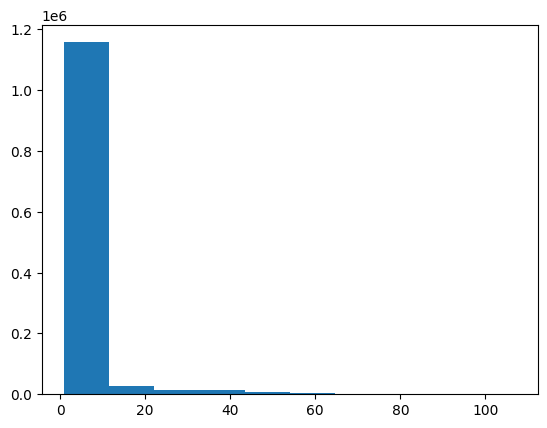

In [79]:
plt.hist(collapsed_results.flatten())

In [80]:
from skimage.morphology import white_tophat, disk
from numpy.typing import NDArray
import cv2
def opencv_dilate_disk(img, r):
    k = 2*r + 1
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    # OpenCV likes uint8/float32; keep float32 if you want

    return cv2.dilate(img, se)

def caps(image, small_r, big_r):
    image1 = image - white_tophat(image, disk(small_r))
    #selem_small, selem_large = disk(small_r), disk(big_r)    
    hats = opencv_dilate_disk(image1, big_r) - opencv_dilate_disk(image1, small_r) 
    clean = image1 - np.minimum(image1, hats) 
    troughs = np.maximum(image1, hats) - image1
    return hats, clean, troughs
#cell_hats = caps(b_eq, 2, 20)

def show_caps(image, small_r, big_r) -> tuple[NDArray, NDArray, NDArray]: # hats, clean, troughs

    hats, clean, troughs = caps(image, small_r, big_r)

    fig, ax = plt.subplots(1,4, figsize=(30,5))
    ax[0].axis('off'); ax[1].axis('off'); ax[2].axis('off'); ax[3].axis('off');
    ax[0].imshow(image, cmap='gray'); ax[0].set_title('Original Image')
    ax[1].imshow(hats, cmap='gray'); ax[1].set_title('Hats')
    ax[2].imshow(clean, cmap='gray'); ax[2].set_title('Clean')
    ax[3].imshow(troughs, cmap='gray'); ax[3].set_title('Troughs')
    fig.colorbar(ax[1].imshow(hats, cmap='gray'), ax=ax[1])
    fig.colorbar(ax[2].imshow(clean, cmap='gray'), ax=ax[2])
    fig.colorbar(ax[3].imshow(troughs, cmap='gray'), ax=ax[3])
    fig.show()
    return hats, clean, troughs

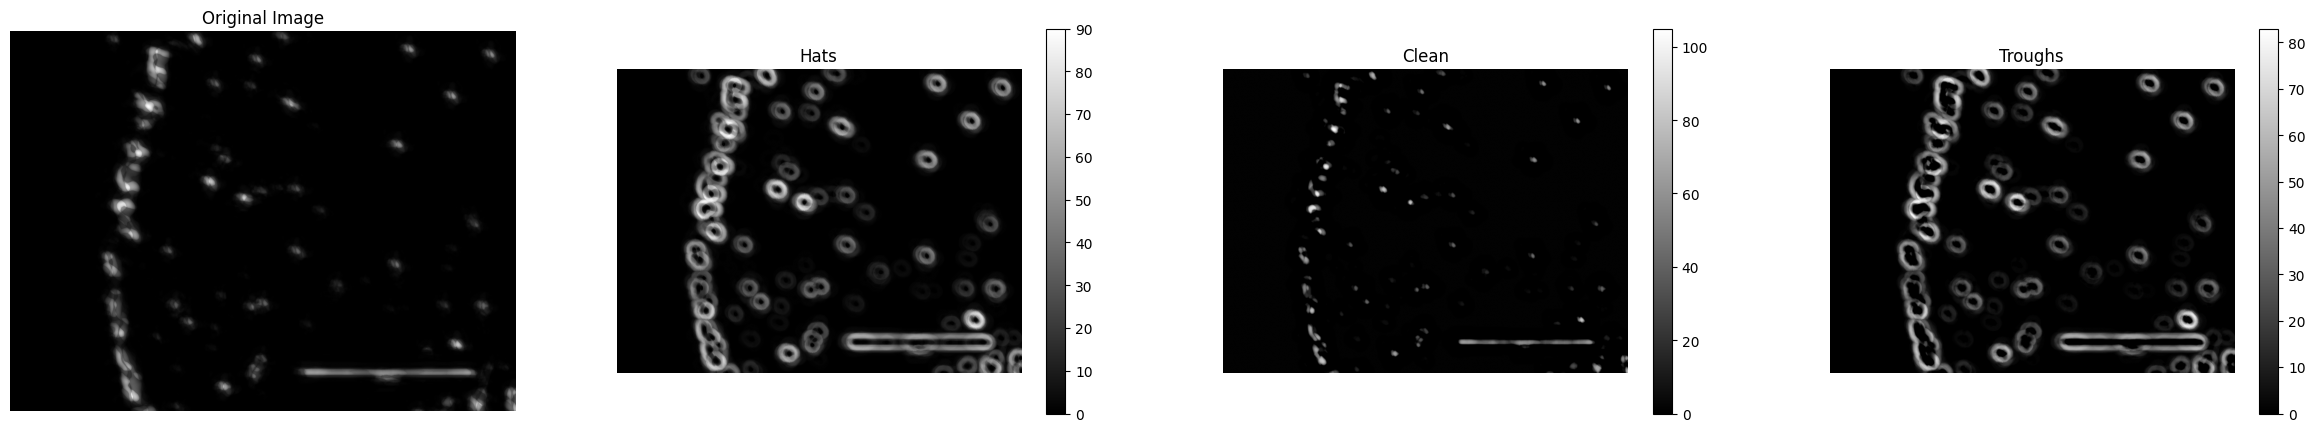

In [81]:
hats, clean, troughs = show_caps(collapsed_results, 2, 20)

Text(0.5, 1.0, 'NDI Label on Otsu Thresholded Clean: 60 features')

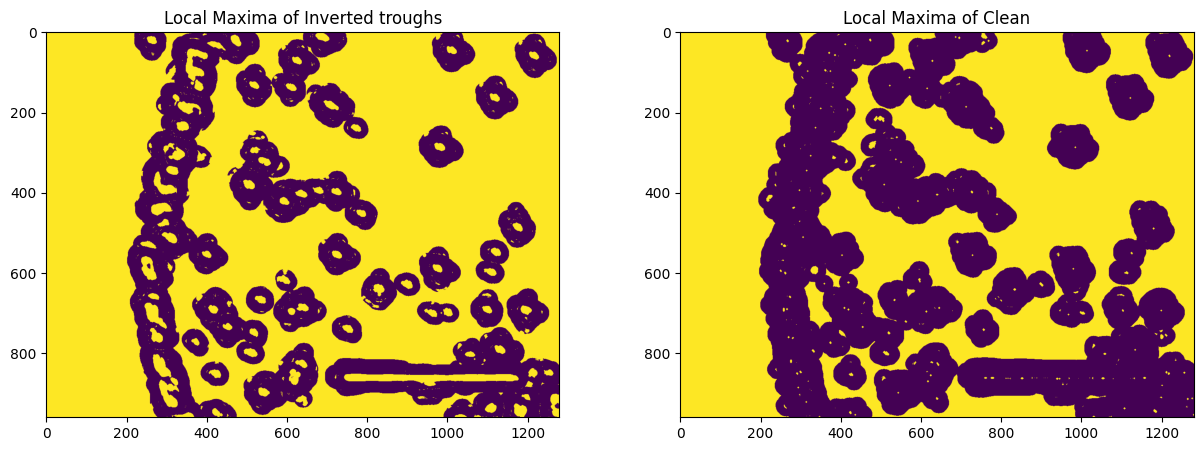

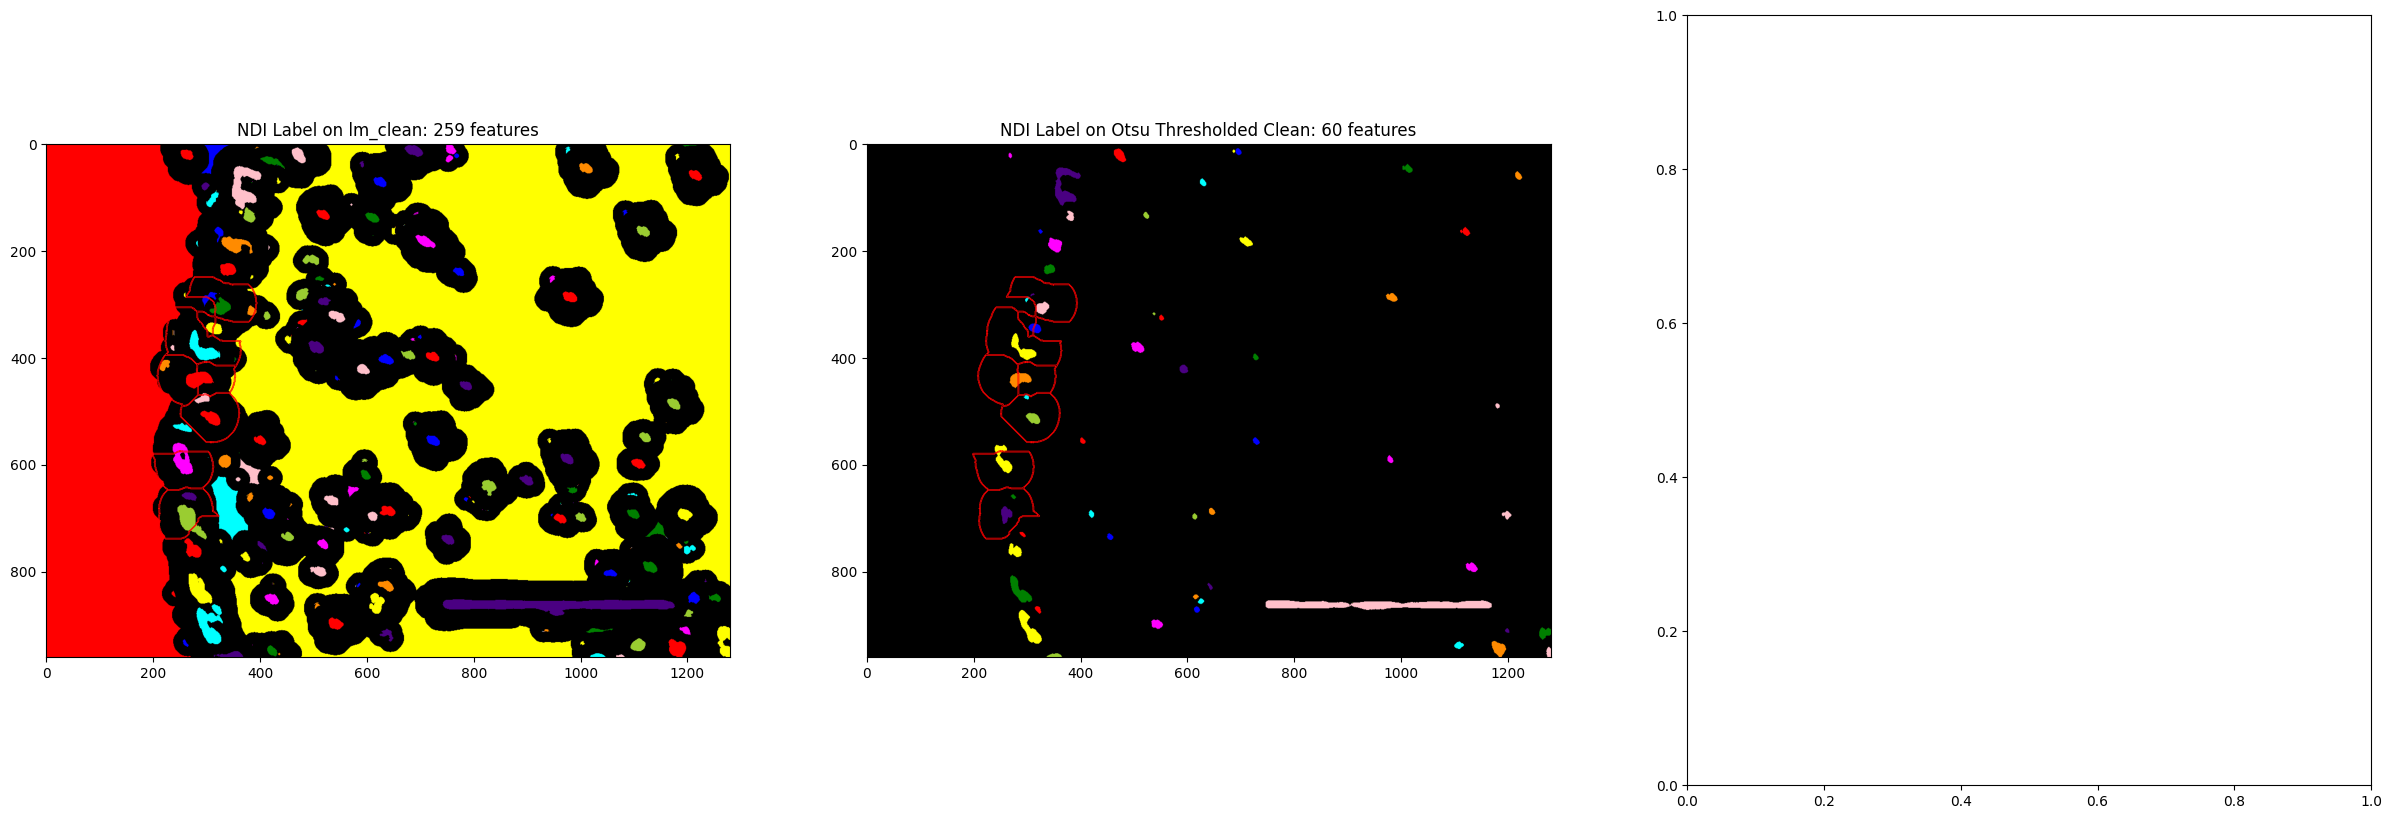

In [82]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
lm_i_troughs = local_maxima(invert(troughs))
lm_clean = local_maxima(clean)
contours_trouphs = find_boundaries((troughs & dilation(best_crypts>0)))

ax[0].imshow(lm_i_troughs)
ax[0].set_title('Local Maxima of Inverted troughs')
ax[1].imshow(lm_clean)
ax[1].set_title('Local Maxima of Clean')

fig, ax = plt.subplots(1,3, figsize=(30,10))

# test variations of ndi label on lm_clean
labeled_lm_clean, num_features = ndi.label(clean)
ax[0].imshow(label2rgb(labeled_lm_clean)); ax[0].contour(boundaries, colors='r', linewidths=0.5)
ax[0].set_title(f'NDI Label on lm_clean: {num_features} features')

# test apply an otsu to clean
from skimage.filters import threshold_otsu
otsu_thresh = threshold_otsu(clean)
binary_clean = clean > otsu_thresh
labeled_binary_clean, num_features_bin = ndi.label(binary_clean)
ax[1].imshow(label2rgb(labeled_binary_clean)); ax[1].contour(boundaries, colors='r', linewidths=0.5)
ax[1].set_title(f'NDI Label on Otsu Thresholded Clean: {num_features_bin} features')

Unique labels in best crypts: [ 0 16 18 19 22 23 27 28 30 33 35 36]


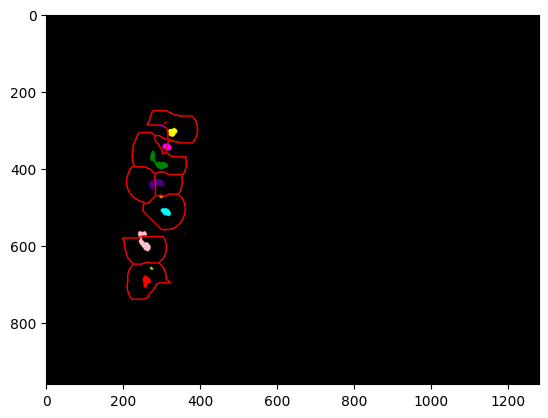

Effective label count in selected labels: K=11, Neff_simpson=6.722204615977401, Neff_shannon=7.655733285112001, ratio_simpson=0.6111095105434001


In [98]:
# find each label in labeled_binary_clean that exists in a region of best_crypts
labeled_binary_clean_overlap_with_best_crypts = np.where(best_crypts > 0, labeled_binary_clean, 0)
# then how do i dump out the names of those labels
unique_labels = np.unique(labeled_binary_clean_overlap_with_best_crypts)
print("Unique labels in best crypts:", unique_labels)
# now show the selected labels from labeld_binary_clean
selected_labels_mask = np.isin(labeled_binary_clean, unique_labels)
selected_labels = np.where(selected_labels_mask, labeled_binary_clean, 0)
plt.imshow(label2rgb(selected_labels)); plt.contour(boundaries, colors='r', linewidths=0.5)
plt.show()
# now i want a normalized count of how many labels we have based on contribution to total labeld area of selected_labels
import numpy as np

def effective_label_count(labels: np.ndarray, region_mask: np.ndarray=None, eps: float=1e-12):
    """
    labels: int array (0 = background; 1..K = labels)
    region_mask: optional bool array selecting the fixed region of interest
    returns:
      K (raw unique count in region, excl. background),
      Neff_simpson (1 / sum p_i^2),
      Neff_shannon (exp(-sum p_i log p_i)),
      ratio_simpson (Neff_simpson / K) or np.nan if K==0
    """
    if region_mask is None:
        region_mask = np.ones_like(labels, dtype=bool)

    sel = labels[region_mask]
    sel = sel[sel > 0]  # drop background

    if sel.size == 0:
        return 0, 0.0, 0.0, np.nan

    K = int(np.unique(sel).size)

    # areas per label (compact, zero-based after excluding bg)
    max_lab = int(sel.max())
    counts = np.bincount(sel, minlength=max_lab + 1)[1:]  # drop index 0 (bg)
    counts = counts[counts > 0]  # keep only present labels
    total = counts.sum()
    p = counts / total

    Neff_simpson = 1.0 / np.sum(p * p)
    Neff_shannon = float(np.exp(-np.sum(p * np.log(p + eps))))
    ratio_simpson = Neff_simpson / K if K > 0 else np.nan

    return K, Neff_simpson, Neff_shannon, ratio_simpson
K, Neff_simpson, Neff_shannon, ratio_simpson = effective_label_count(selected_labels)
print(f"Effective label count in selected labels: K={K}, Neff_simpson={Neff_simpson}, Neff_shannon={Neff_shannon}, ratio_simpson={ratio_simpson}")
